In [1]:
# package imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt 

In [2]:
gss = pd.read_csv('Data/gss18.csv', low_memory=False)

In [3]:
interesting_variables = ['LONELY2', 'SATJOB', 'MOREDAYS', 'WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC', 'AGE','MARITAL', 'EDUC']
# testing ridding of s
# GSS rid of HOMPOP, will HOUSEHOLD SIZE use from AARP
gss = gss[interesting_variables]

## Preprocessing

In [4]:
# how many nulls?
# Loop through each column
# and check the amount of nulls.
# Only print if there are more than 0.

for col in gss.columns:
    if gss[col].isnull().sum() > 0:
        print(f'{round(gss[col].isnull().sum()/gss.shape[0],3)}%\t{gss[col].isnull().sum()} null values in {col}')

0.503%	1182 null values in LONELY2
0.259%	609 null values in SATJOB
0.403%	947 null values in MOREDAYS
0.396%	930 null values in WRKHOME
0.008%	19 null values in HLTHPHYS
0.008%	19 null values in HLTHMNTL
0.503%	1180 null values in CONWKDAY
0.503%	1182 null values in PARTLSC
0.003%	7 null values in AGE
0.001%	2 null values in MARITAL
0.001%	3 null values in EDUC


In [5]:
# recode social isolation
gss['is_si'] = gss['LONELY2'].apply(lambda x: 1 if (x == 3 or x == 4 or x == 5) else 0)

In [6]:
# bin wkdays
bins = [-1,0,7,14,21,31]#pd.IntervalIndex.from_tuples([(-1,1), (1, 7), (7, 14), (14, 21),(21,30)])


gss['MOREWEEKS'] = pd.cut(gss['MOREDAYS'],bins,labels=['0','1','2','3','4'])

In [7]:
bins = [18,29,44,59,89]#,pd.IntervaIndex.from_tuples([(18, 29), (30, 44), (45, 59),(60,89)])


gss['Age Group'] = pd.cut(gss['AGE'],bins,labels=[1,2,3,4])

####### Age group ########

In [8]:
bins= [0,11,12,15,21]
gss['EDUC'] = pd.cut(gss['EDUC'],bins,labels=[1,2,3,4])#labels=['No HS Diploma','HS Graduate','Some College','BA or Above'])
######## EDUCATION ######

## Decision Tree

In [9]:
clf = DecisionTreeClassifier(random_state=0)

In [10]:
gss = gss.dropna()
for colm in gss.columns:
    print(f'{colm}: \t{gss[colm].unique()}')

LONELY2: 	[2. 3. 1. 4. 5.]
SATJOB: 	[1. 2. 3. 4.]
MOREDAYS: 	[ 2.  1. 24.  3.  6.  0. 15. 30. 20. 12. 18.  5.  4. 10. 26. 25.  8. 28.
  7. 17. 22. 14. 23.  9. 16.]
WRKHOME: 	[1. 4. 5. 6. 2. 3.]
HLTHPHYS: 	[1. 3. 2. 4. 5.]
HLTHMNTL: 	[1. 2. 3. 4. 5.]
CONWKDAY: 	[4. 3. 2. 6. 1. 5.]
PARTLSC: 	[3. 2. 5. 1. 4.]
AGE: 	[63. 59. 43. 55. 34. 44. 40. 30. 20. 65. 46. 22. 23. 28. 37. 42. 21. 70.
 53. 29. 50. 56. 67. 54. 48. 76. 39. 69. 60. 35. 38. 26. 57. 19. 36. 61.
 33. 51. 58. 45. 52. 25. 27. 24. 77. 47. 74. 32. 31. 72. 66. 68. 49. 64.
 41. 71. 78. 75. 85. 73. 62. 89.]
MARITAL: 	[1. 3. 5. 4. 2.]
EDUC: 	[4, 3, 2, 1]
Categories (4, int64): [1 < 2 < 3 < 4]
is_si: 	[0 1]
MOREWEEKS: 	['1', '4', '0', '3', '2']
Categories (5, object): ['0' < '1' < '2' < '3' < '4']
Age Group: 	[4, 3, 2, 1]
Categories (4, int64): [1 < 2 < 3 < 4]


### make x and y

In [11]:
x = gss.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
y = gss['is_si']
x.shape

(688, 10)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)#,stratify=x['MOREWEEKS'])

In [13]:
# decision tree regular fit
clf.fit(x_train,y_train)
clf.score(x_test, y_test)

0.6447368421052632

In [14]:
# baseline
gss['is_si'].value_counts()[0]/gss['is_si'].value_counts().sum()
# 79% baseline. awkward.

0.7558139534883721

In [15]:
# 79%... what quantities?
gss['is_si'].value_counts()

0    520
1    168
Name: is_si, dtype: int64

In [16]:
# prepare grid search
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'max_leaf_nodes': range(2,1000,22),
    'max_features': ['auto', 'sqrt', 'log2'], # all of the feature types
    'max_depth' : range(1,100, 5), # again, steps of 25
    'criterion' :['gini', 'entropy', 'log_loss'], # the two common criterion 
    'max_features': ['sqrt', 'log2', None]
}

In [17]:
# do the grid search
CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1) 
CV_DT.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 100, 5),
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': range(2, 1000, 22)})

In [18]:
CV_DT.score(x_test, y_test)

0.7631578947368421

In [19]:
x.head()

,SATJOB,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,MARITAL,EDUC,MOREWEEKS,Age Group
3,1.0,1.0,1.0,1.0,4.0,3.0,1.0,4,1,4
6,1.0,1.0,3.0,2.0,3.0,2.0,3.0,3,1,3
7,1.0,1.0,2.0,3.0,4.0,5.0,5.0,2,4,2
9,2.0,1.0,2.0,3.0,4.0,1.0,1.0,2,1,3
11,2.0,1.0,3.0,3.0,2.0,1.0,4.0,3,1,2


## upsampling is_si

In [20]:
to_resample = gss.loc[gss['is_si'] ==1]
our_resample = to_resample.sample(n = 396, replace = True)
gss_rebal = pd.concat([gss, our_resample])

In [21]:
x = gss_rebal.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
y = gss_rebal['is_si']
x.shape

(1084, 10)

In [22]:
gss_rebal['is_si'].value_counts()

1    564
0    520
Name: is_si, dtype: int64

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [24]:
clf.fit(x_train,y_train)
clf.score(x_test, y_test)

0.8631284916201117

In [25]:
param_grid = { 
    'max_leaf_nodes': range(2,1000,22),
    'max_features': ['auto', 'sqrt', 'log2'], # all of the feature types
    'max_depth' : range(1,100, 5), # again, steps of 25
    'criterion' :['gini', 'entropy', 'log_loss'], # the two common criterion 
    'max_features': ['sqrt', 'log2', None]
}

In [26]:
CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1) 
CV_DT.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 100, 5),
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': range(2, 1000, 22)})

In [27]:
CV_DT.score(x_test, y_test)

0.8324022346368715

In [28]:
x.shape

(1084, 10)

In [29]:
for importance, feature in zip(clf.feature_importances_, clf.feature_names_in_):
    print(f'{round(importance,3)}\t{feature}')

0.08	SATJOB
0.095	WRKHOME
0.099	HLTHPHYS
0.169	HLTHMNTL
0.128	CONWKDAY
0.081	PARTLSC
0.099	MARITAL
0.064	EDUC
0.066	MOREWEEKS
0.119	Age Group


In [30]:
# DT for each age category
for ages in gss['Age Group'].unique():
    print(f'---------- ages {ages}-----------')
    age_gss = gss_rebal.loc[gss_rebal['Age Group'] == ages]
    x = age_gss.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
    y = age_gss['is_si']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    clf.fit(x_train,y_train)
    print(f'{round(clf.score(x_test, y_test),3)}% {ages}')
    
    for importance, feature in zip(clf.feature_importances_, clf.feature_names_in_):
        print(f'{round(importance,3)}\t{feature}')

---------- ages 4-----------
0.887% 4
0.0	SATJOB
0.128	WRKHOME
0.185	HLTHPHYS
0.339	HLTHMNTL
0.084	CONWKDAY
0.034	PARTLSC
0.053	MARITAL
0.095	EDUC
0.082	MOREWEEKS
0.0	Age Group
---------- ages 3-----------
0.822% 3
0.044	SATJOB
0.086	WRKHOME
0.104	HLTHPHYS
0.349	HLTHMNTL
0.051	CONWKDAY
0.096	PARTLSC
0.119	MARITAL
0.118	EDUC
0.034	MOREWEEKS
0.0	Age Group
---------- ages 2-----------
0.84% 2
0.084	SATJOB
0.125	WRKHOME
0.05	HLTHPHYS
0.068	HLTHMNTL
0.116	CONWKDAY
0.128	PARTLSC
0.232	MARITAL
0.066	EDUC
0.13	MOREWEEKS
0.0	Age Group
---------- ages 1-----------
0.73% 1
0.075	SATJOB
0.123	WRKHOME
0.135	HLTHPHYS
0.072	HLTHMNTL
0.118	CONWKDAY
0.0	PARTLSC
0.136	MARITAL
0.252	EDUC
0.089	MOREWEEKS
0.0	Age Group


[Text(0.4383375050566343, 0.975, 'MARITAL <= 1.5\nentropy = 0.998\nsamples = 726\nvalue = [344, 382]\nclass = WRKHOME'),
 Text(0.1672734627831715, 0.925, 'SATJOB <= 1.5\nentropy = 0.892\nsamples = 259\nvalue = [179, 80]\nclass = SATJOB'),
 Text(0.07402912621359223, 0.875, 'Age Group <= 1.5\nentropy = 0.786\nsamples = 145\nvalue = [111, 34]\nclass = SATJOB'),
 Text(0.06755663430420712, 0.825, 'entropy = 0.0\nsamples = 6\nvalue = [6, 0]\nclass = SATJOB'),
 Text(0.08050161812297735, 0.825, 'CONWKDAY <= 2.5\nentropy = 0.803\nsamples = 139\nvalue = [105, 34]\nclass = SATJOB'),
 Text(0.038834951456310676, 0.775, 'WRKHOME <= 5.5\nentropy = 0.477\nsamples = 39\nvalue = [35, 4]\nclass = SATJOB'),
 Text(0.025889967637540454, 0.725, 'WRKHOME <= 2.0\nentropy = 0.323\nsamples = 34\nvalue = [32, 2]\nclass = SATJOB'),
 Text(0.019417475728155338, 0.675, 'MOREWEEKS <= 0.5\nentropy = 0.469\nsamples = 20\nvalue = [18, 2]\nclass = SATJOB'),
 Text(0.012944983818770227, 0.625, 'HLTHMNTL <= 1.5\nentropy = 0.

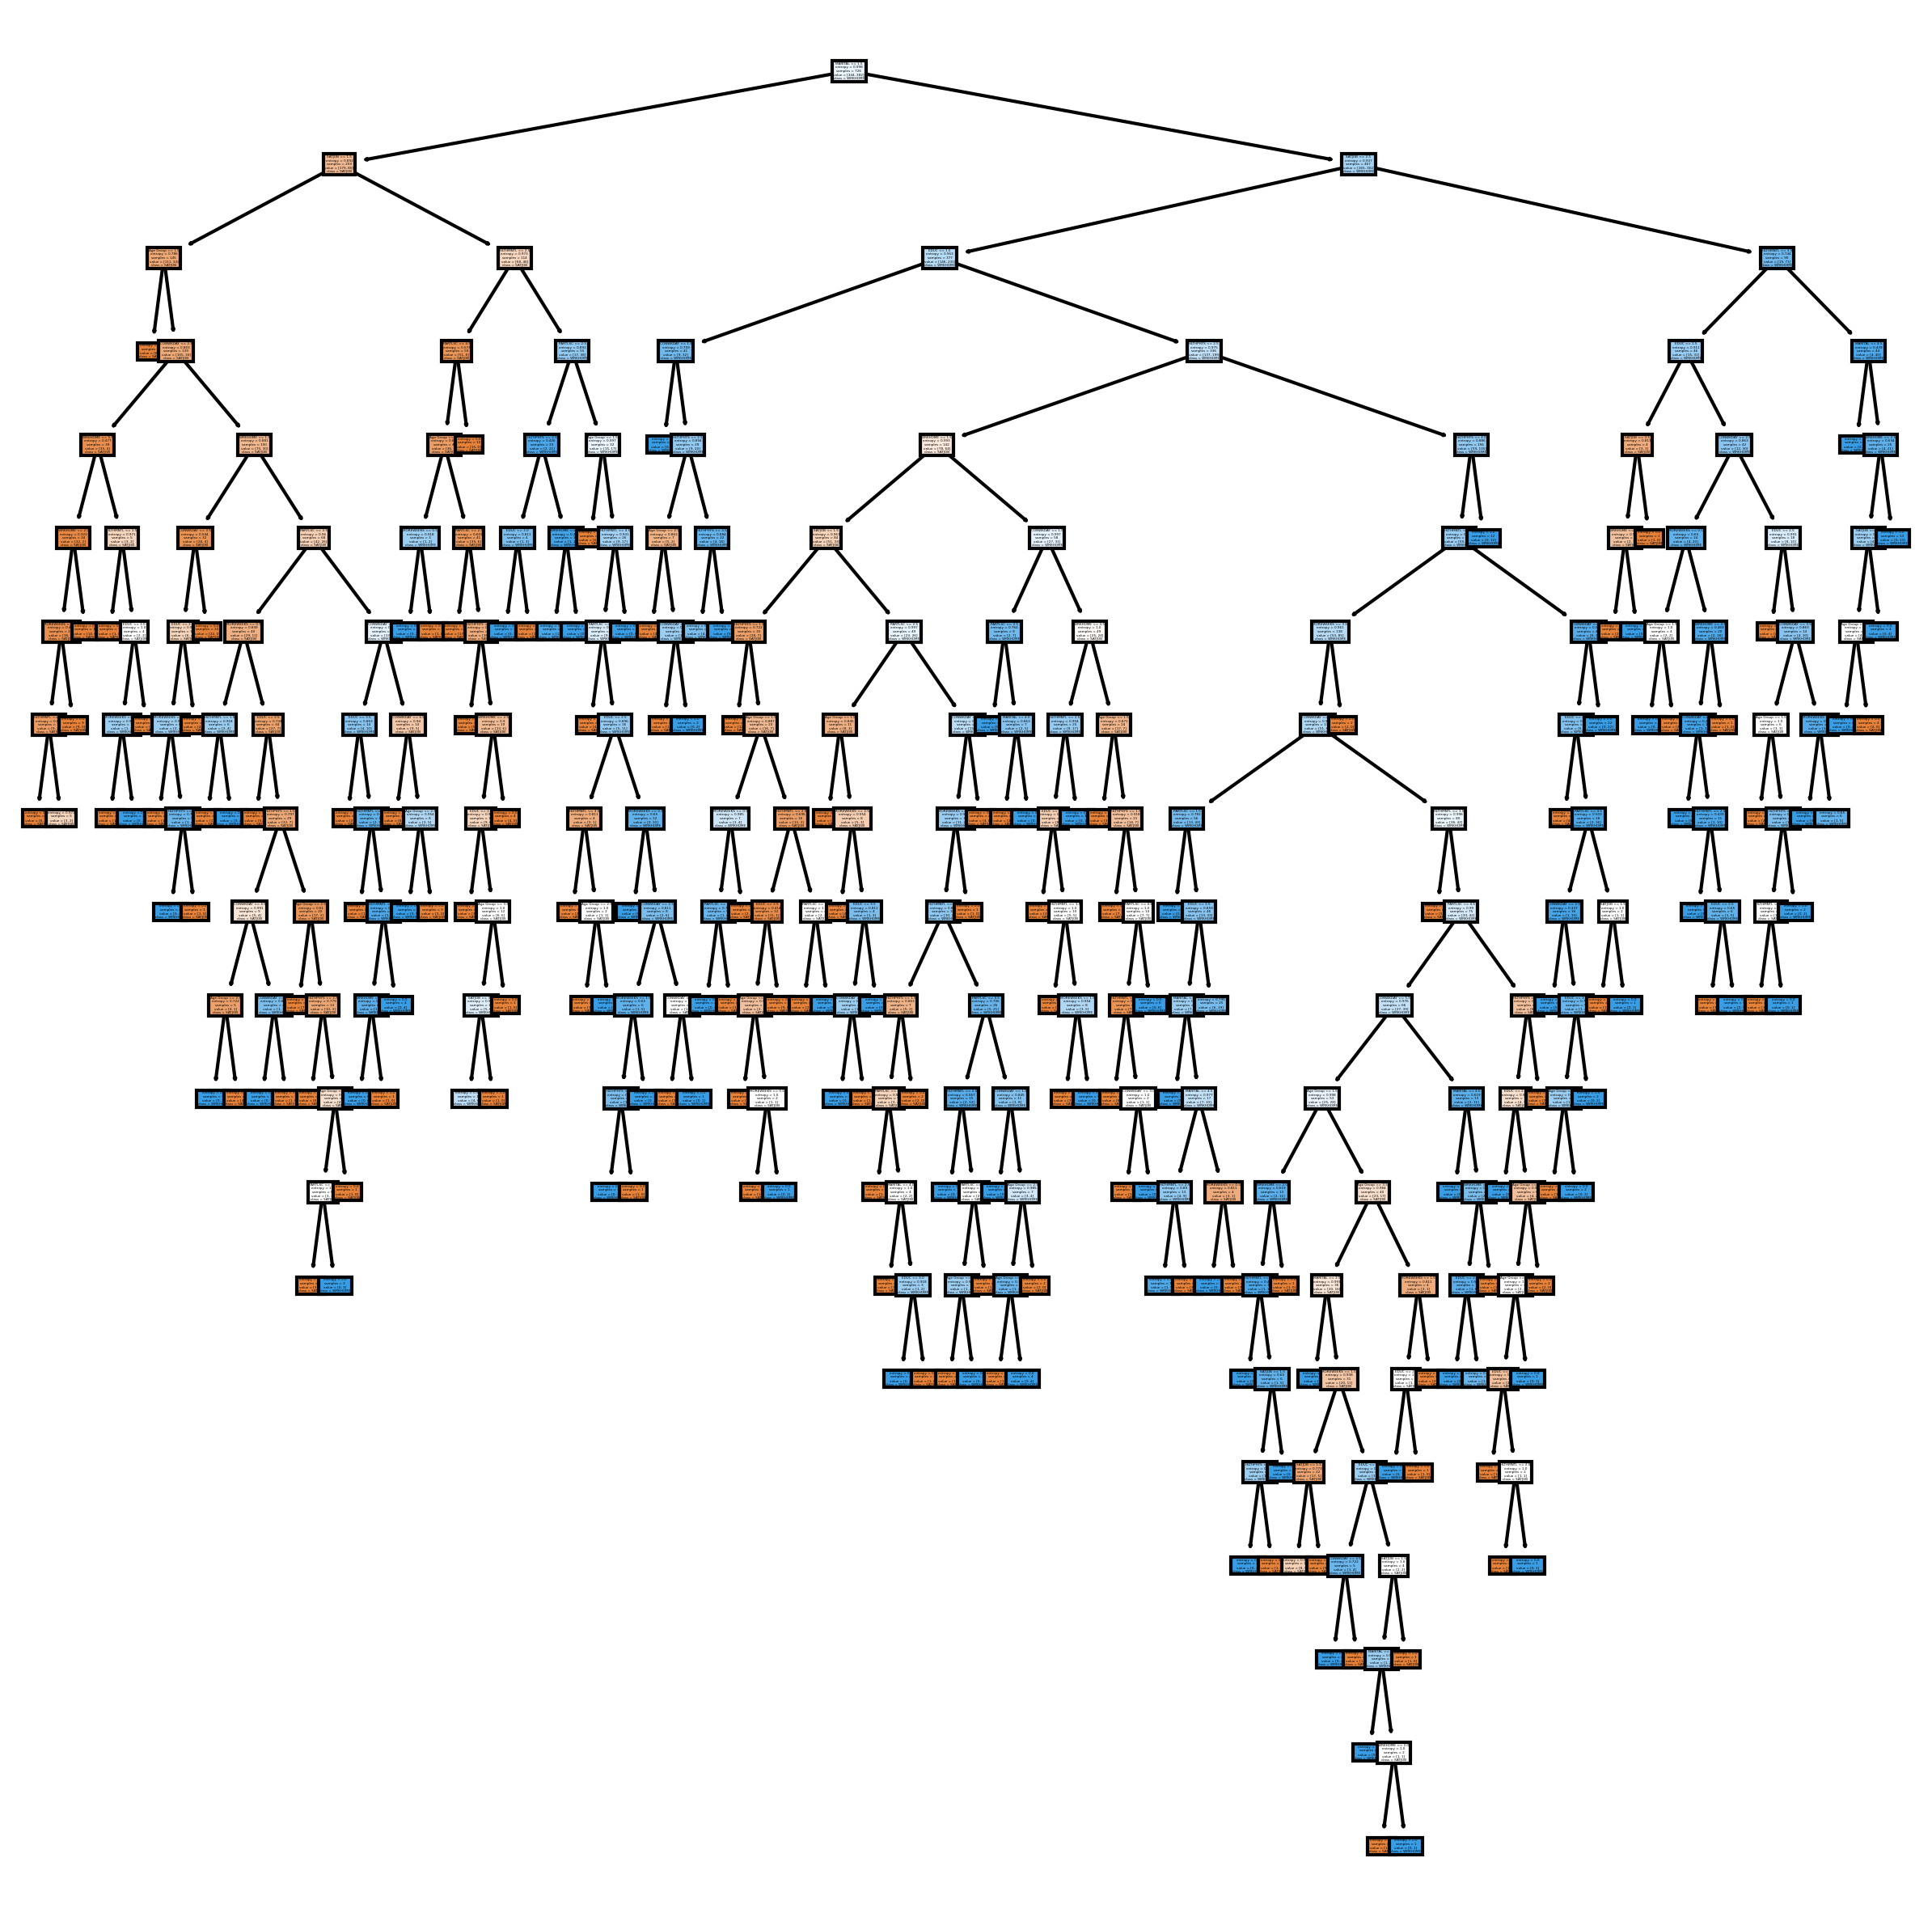

In [31]:
fix, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10), dpi=300)
tree.plot_tree(CV_DT.best_estimator_, feature_names = x.columns, class_names = CV_DT.feature_names_in_, filled = True)

In [32]:
# upsample training data only CHECK
# fix tree????
# trim down unncessary vars?
# make output legible CHECK
# seperate modeling from data manip, gss and aarp 
# linear 

## Upsampling only training data

In [33]:
# make train and test set
gss_train, gss_test = train_test_split(gss, test_size=0.33, random_state=42)

In [34]:
# upsample train set
to_resample = gss_train.loc[gss['is_si'] ==1]
our_resample = to_resample.sample(n = 396, replace = True)
gss_train_rebal = pd.concat([gss_train, our_resample])

In [35]:
# manually create x,y test and trains
x_train = gss_train_rebal.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
x_test = gss_test.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
y_train = gss_train_rebal['is_si']
y_test = gss_test['is_si']

In [36]:
# grid search it yeah
CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1) 
CV_DT.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 100, 5),
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': range(2, 1000, 22)})

In [37]:
CV_DT.score(x_test, y_test)

0.6491228070175439

In [56]:
#Creating dataframes to hold feature importances
fi_df1 = pd.DataFrame()
fi_df2 = pd.DataFrame()
fi_df3 = pd.DataFrame()
fi_df4 = pd.DataFrame()

In [57]:
from imblearn.over_sampling import SMOTEN
# DT for each age category
for ages in gss['Age Group'].unique():
    #print(f'---------- ages {ages} -----------')
    
    # grab gss for single age group
    aged_gss = gss.loc[gss['Age Group'] == ages]
    
    # split into train and test
    gss_train, gss_test = train_test_split(aged_gss, test_size=0.33, random_state=42)
    # upsample train set
    
    sm = SMOTEN(random_state=42)
    
    # manually create x,y test and trains
    x_train = gss_train_rebal.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
    x_test = gss_test.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
    y_train = gss_train_rebal['is_si']
    y_test = gss_test['is_si']
    
    x_train, y_train = sm.fit_resample(x_train, y_train)
    
    # new decision tree
    clf = DecisionTreeClassifier(random_state=42)
    
    # grid to search
    param_grid = { 
    'max_leaf_nodes': range(2,1000,11),
    'max_features': ['auto', 'sqrt', 'log2'], # all of the feature types
    'max_depth' : range(1,100, 3),
    'criterion' :['gini', 'entropy', 'log_loss'], # the two common criterion 
    'max_features': ['sqrt', 'log2', None]
}
    # new grid search using decision tree and grid from above
    CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1) 
    
    # let's 'train'
    CV_DT.fit(x_train, y_train)
    
    # print the results
    print(f'---------- score for age {ages}: {round(CV_DT.score(x_test, y_test),3)}% ----------')
    
    for importance, feature in zip(CV_DT.best_estimator_.feature_importances_, CV_DT.feature_names_in_):
        print(f'{round(importance,3)}\t{feature}')
        
        #Saving summary data to a dataframe for plots
        if ages ==1:
            fi_new = {'importance': (round(importance,3)), 'feature': feature}
            fi_df1 = fi_df1.append(fi_new, ignore_index = True)

        if ages==2:
            fi_new = {'importance': (round(importance,3)), 'feature': feature}
            fi_df2 = fi_df2.append(fi_new, ignore_index = True)
        if ages==3:
            fi_new = {'importance': (round(importance,3)), 'feature': feature}
            fi_df3 = fi_df3.append(fi_new, ignore_index = True)

        if ages==4:
            fi_new = {'importance': (round(importance,3)), 'feature': feature}
            fi_df4 = fi_df4.append(fi_new, ignore_index = True)
        
    ###### print train and test set sizes
    print(f'training set size: \n{y_train.value_counts()}')
    print(f'testing set size:  \n{y_test.value_counts()}')
    ###### 


---------- score for age 4: 0.939% ----------
0.038	SATJOB
0.106	WRKHOME
0.101	HLTHPHYS
0.154	HLTHMNTL
0.099	CONWKDAY
0.099	PARTLSC
0.096	MARITAL
0.112	EDUC
0.102	MOREWEEKS
0.093	Age Group
training set size: 
0    510
1    510
Name: is_si, dtype: int64
testing set size:  
0    28
1     5
Name: is_si, dtype: int64


/var/folders/mz/014fyjcn1l5dpw0r1m5r57580000gn/T/ipykernel_8457/1493621968.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fi_df4 = fi_df4.append(fi_new, ignore_index = True)
/var/folders/mz/014fyjcn1l5dpw0r1m5r57580000gn/T/ipykernel_8457/1493621968.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fi_df4 = fi_df4.append(fi_new, ignore_index = True)
/var/folders/mz/014fyjcn1l5dpw0r1m5r57580000gn/T/ipykernel_8457/1493621968.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fi_df4 = fi_df4.append(fi_new, ignore_index = True)
/var/folders/mz/014fyjcn1l5dpw0r1m5r57580000gn/T/ipykernel_8457/1493621968.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

---------- score for age 3: 0.899% ----------
0.038	SATJOB
0.106	WRKHOME
0.101	HLTHPHYS
0.154	HLTHMNTL
0.099	CONWKDAY
0.099	PARTLSC
0.096	MARITAL
0.112	EDUC
0.102	MOREWEEKS
0.093	Age Group
training set size: 
0    510
1    510
Name: is_si, dtype: int64
testing set size:  
0    50
1    19
Name: is_si, dtype: int64


/var/folders/mz/014fyjcn1l5dpw0r1m5r57580000gn/T/ipykernel_8457/1493621968.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fi_df3 = fi_df3.append(fi_new, ignore_index = True)
/var/folders/mz/014fyjcn1l5dpw0r1m5r57580000gn/T/ipykernel_8457/1493621968.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fi_df3 = fi_df3.append(fi_new, ignore_index = True)
/var/folders/mz/014fyjcn1l5dpw0r1m5r57580000gn/T/ipykernel_8457/1493621968.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fi_df3 = fi_df3.append(fi_new, ignore_index = True)
/var/folders/mz/014fyjcn1l5dpw0r1m5r57580000gn/T/ipykernel_8457/1493621968.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

---------- score for age 2: 0.869% ----------
0.038	SATJOB
0.106	WRKHOME
0.101	HLTHPHYS
0.154	HLTHMNTL
0.099	CONWKDAY
0.099	PARTLSC
0.096	MARITAL
0.112	EDUC
0.102	MOREWEEKS
0.093	Age Group
training set size: 
0    510
1    510
Name: is_si, dtype: int64
testing set size:  
0    68
1    16
Name: is_si, dtype: int64


/var/folders/mz/014fyjcn1l5dpw0r1m5r57580000gn/T/ipykernel_8457/1493621968.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fi_df2 = fi_df2.append(fi_new, ignore_index = True)
/var/folders/mz/014fyjcn1l5dpw0r1m5r57580000gn/T/ipykernel_8457/1493621968.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fi_df2 = fi_df2.append(fi_new, ignore_index = True)
/var/folders/mz/014fyjcn1l5dpw0r1m5r57580000gn/T/ipykernel_8457/1493621968.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fi_df2 = fi_df2.append(fi_new, ignore_index = True)
/var/folders/mz/014fyjcn1l5dpw0r1m5r57580000gn/T/ipykernel_8457/1493621968.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

---------- score for age 1: 0.86% ----------
0.038	SATJOB
0.106	WRKHOME
0.101	HLTHPHYS
0.154	HLTHMNTL
0.099	CONWKDAY
0.099	PARTLSC
0.096	MARITAL
0.112	EDUC
0.102	MOREWEEKS
0.093	Age Group
training set size: 
0    510
1    510
Name: is_si, dtype: int64
testing set size:  
0    29
1    14
Name: is_si, dtype: int64


/var/folders/mz/014fyjcn1l5dpw0r1m5r57580000gn/T/ipykernel_8457/1493621968.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fi_df1 = fi_df1.append(fi_new, ignore_index = True)
/var/folders/mz/014fyjcn1l5dpw0r1m5r57580000gn/T/ipykernel_8457/1493621968.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fi_df1 = fi_df1.append(fi_new, ignore_index = True)
/var/folders/mz/014fyjcn1l5dpw0r1m5r57580000gn/T/ipykernel_8457/1493621968.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fi_df1 = fi_df1.append(fi_new, ignore_index = True)
/var/folders/mz/014fyjcn1l5dpw0r1m5r57580000gn/T/ipykernel_8457/1493621968.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

In [65]:
#Add a new column in each summary dataframe that indicates the Age group of the dataframe
fi_df1['Age Group'] = '18-29'
fi_df2['Age Group'] = '30-44'
fi_df3['Age Group'] = '45-59'
fi_df4['Age Group'] = '60+'

#Create a new data frame to hold data that will be used for plotting
summary_plot = pd.concat([fi_df1,fi_df2,fi_df3,fi_df4])


In [71]:
summary_plot.replace(to_replace={'HLTHPHYS': 'Physical Health',
                         'CONWKDAY':'# of Weekday Interactions', 
                         'HLTHMNTL':'Mental Health',
                         'MOREWEEKS':'Extra Hours Worked',
                         'MARITAL':'Marital Status',
                         'PARTLSC':'Participation in groups',
                         'SATJOB':'Job Satisfaction',
                         'WRKHOME':'Work from Home',
                         'EDUC': 'Education'},inplace=True)

Text(0.5, 0, 'Importance Level')

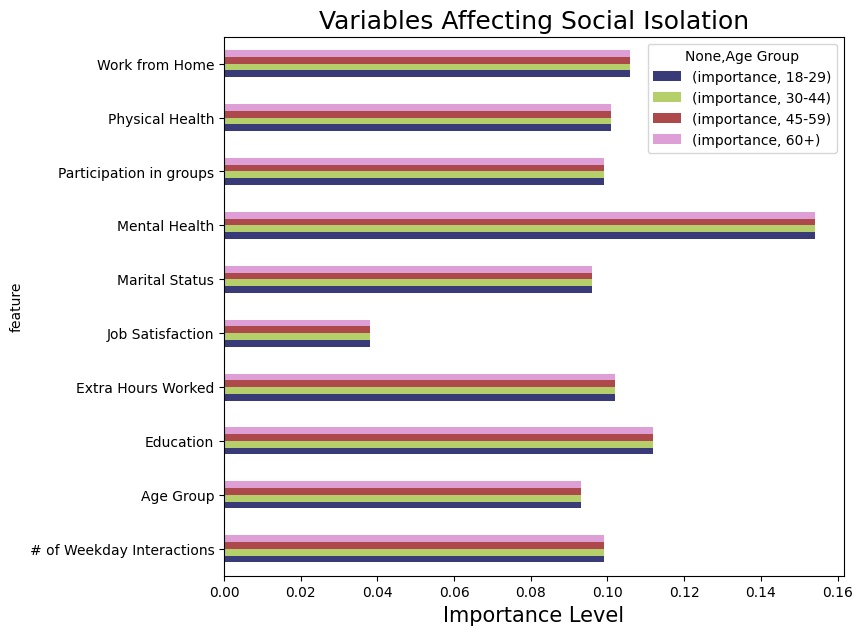

In [97]:
#plt.figure(figsize=(10,10))
ax = summary_plot.pivot(index='feature',columns='Age Group').plot.barh(figsize=(8,7),rot=0,cmap='tab20b')

plt.title('Variables Affecting Social Isolation', fontsize=18)
plt.xlabel('Importance Level',fontsize=15)
#plt.ylabel('Feature',fontsize=15)
#ax.tick_params(axis='x',labelsize=12)
#ax.tick_params(axis='y', labelsize=10)
#ax.set_yticklabels(['# of Weekday Interactions', 'Mental Health', 'Physical Health','Job Overtime','Married','Participation in Groups','Job Satisfaction','Work From Home'])
#plt.setp(ax.yaxis.get_majorticklabels(), ha="right" )

In [95]:
summary_plot.pivot(index='feature',columns='Age Group')

importance                     
Age Group                      18-29  30-44  45-59    60+
feature                                                  
# of Weekday Interactions      0.099  0.099  0.099  0.099
Age Group                      0.093  0.093  0.093  0.093
Education                      0.112  0.112  0.112  0.112
Extra Hours Worked             0.102  0.102  0.102  0.102
Job Satisfaction               0.038  0.038  0.038  0.038
Marital Status                 0.096  0.096  0.096  0.096
Mental Health                  0.154  0.154  0.154  0.154
Participation in groups        0.099  0.099  0.099  0.099
Physical Health                0.101  0.101  0.101  0.101
Work from Home                 0.106  0.106  0.106  0.106